In [1]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import copy
import logging
import contextily as cx
import gtfs_kit as gk
import fastsim as fsim
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory, busnetwork
from openbustools.drivecycle.physics import conditions, energy, vehicle

In [5]:
epsg = 32148
timezone = "America/Los_Angeles"
coord_ref_center = [386910,69022]
chop_n = 500
point_sep_m = 200
dem_file = Path("..","data","kcm_spatial","usgs10m_dem_32148.tif")
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime","gnss_validated").glob("*") if x.is_dir()]
realtime_folder = Path("..","data","kcm_sensor_realtime")
gnss_solution_file = Path("..","data","gnss","CEErover_solution_20240312160029.LLH")

veh = fsim.vehicle.Vehicle.from_vehdb(63, veh_file=Path("..", "data", "FASTSim_py_veh_db.csv")) # New Flyer XE40

model_folder = "../logs_no_resample"
run_label = "/mix"
model_type = "GRU"
fold_num = 0
version = "version_0"
model = model_utils.load_model(model_folder, run_label, model_type, fold_num, version=version)
model.eval()

GRU(
  (loss_fn): MSELoss()
  (min_em): MinuteEmbedding(
    (em): Embedding(1440, 48)
  )
  (day_em): DayEmbedding(
    (em): Embedding(7, 4)
  )
  (rnn): GRU(5, 32, num_layers=3, dropout=0.1)
  (feature_extract): Linear(in_features=84, out_features=1, bias=True)
  (feature_extract_activation): ReLU()
)

### Altoona, FastSIM Standardized Cycle Comparison (validate BEB model)

In [6]:
altoona_economy = {
    "manhattan.csv": (2767 / 1000),
    "orange_county.csv": (2176 / 1000),
    "hd_udds.csv": (1980 / 1000)
}
economies = []
for cycle_file in ["manhattan.csv", "orange_county.csv", "hd_udds.csv"]:
    df = pd.read_csv(Path("..","data",cycle_file))
    cycle = {
        "cycSecs": df["Time (seconds)"].to_numpy(),
        "cycMps": df["Speed (mph)"].to_numpy() * 0.44704,
        "cycGrade": np.zeros(df.shape[0]),
        "cycRoadType": np.zeros(df.shape[0])
    }
    cycle = fsim.cycle.Cycle.from_dict(cycle)
    sim_drive = fsim.simdrive.SimDrive(cycle, veh)
    sim_drive.sim_drive()
    economies.append(sim_drive.battery_kwh_per_mi)
for i,cycle_file in enumerate(["manhattan.csv", "orange_county.csv", "hd_udds.csv"]):
    print(f"{cycle_file}: (FASTSim BEB): {economies[i]:.2f} kWh/mi | (Altoona: {altoona_economy[cycle_file]:.2f} kWh/mi)")

2024-04-24 11:47:30.281 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00767 exceeds tolerance of 0.001
2024-04-24 11:47:30.640 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00386 exceeds tolerance of 0.001
2024-04-24 11:47:30.641 | simdrive.py:2290 | WARNING: trace miss speed 1.62466 m/s exceeds tolerance of 1.0 m/s


manhattan.csv: (FASTSim BEB): 2.75 kWh/mi | (Altoona: 2.77 kWh/mi)
orange_county.csv: (FASTSim BEB): 2.00 kWh/mi | (Altoona: 2.18 kWh/mi)
hd_udds.csv: (FASTSim BEB): 1.99 kWh/mi | (Altoona: 1.98 kWh/mi)


'hd_udds.csv'

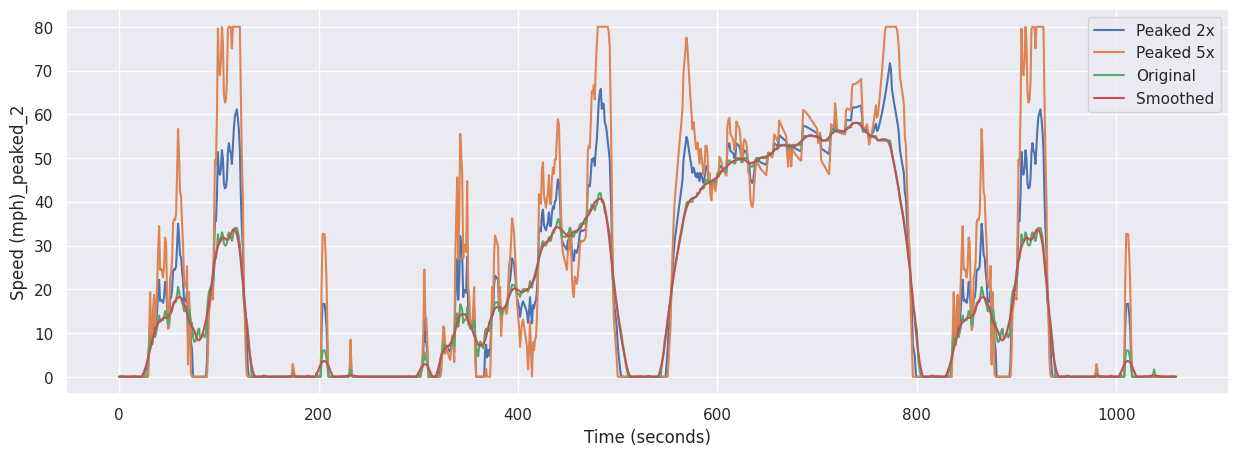

In [7]:
# Smooth or increase velocity peaks
df['Speed (mph)_smoothed'] = spatial.apply_sg_filter(df["Speed (mph)"].to_numpy(), clip_min=0, clip_max=80)
df['Speed (mph)_peaked_2'] = spatial.apply_peak_filter(df['Speed (mph)'].to_numpy(), scalar=2.0, window_len=51, clip_min=0, clip_max=80)
df['Speed (mph)_peaked_5'] = spatial.apply_peak_filter(df['Speed (mph)'].to_numpy(), scalar=5.0, window_len=51, clip_min=0, clip_max=80)

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_peaked_2"], ax=axes, label="Peaked 2x")
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_peaked_5"], ax=axes, label="Peaked 5x")
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)"], ax=axes, label="Original")
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_smoothed"], ax=axes, label="Smoothed")
cycle_file

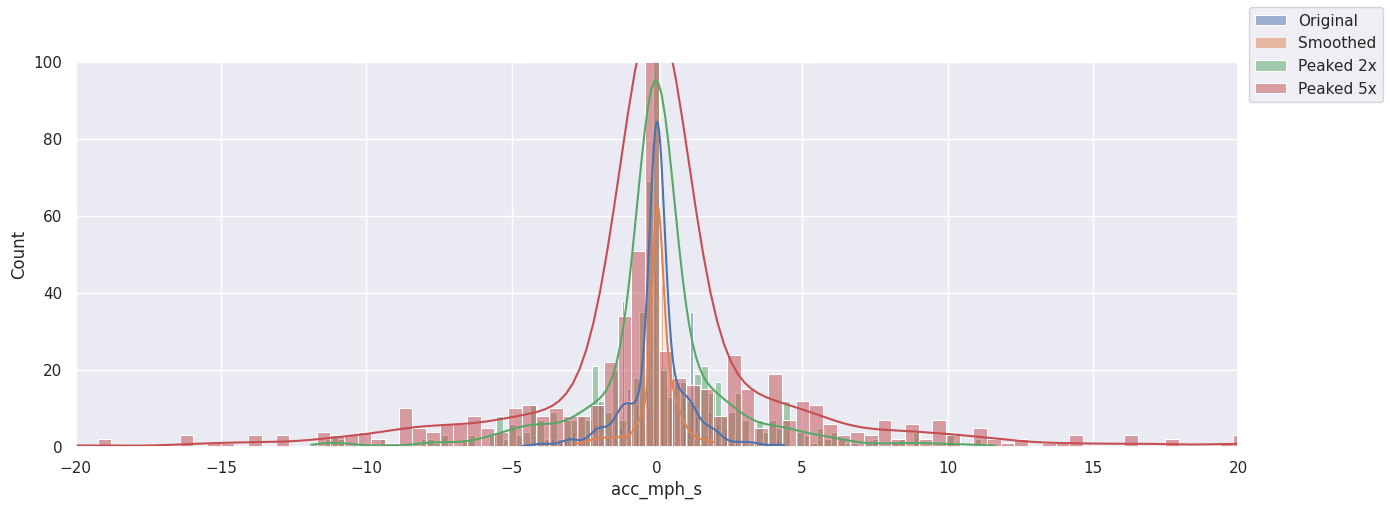

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
df['acc_mph_s'] = df['Speed (mph)'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_smoothed'] = df['Speed (mph)_smoothed'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_peaked_2'] = df['Speed (mph)_peaked_2'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_peaked_5'] = df['Speed (mph)_peaked_5'].diff() / df['Time (seconds)'].diff()
sns.histplot(df['acc_mph_s'], bins=100, kde=True, label="Original", ax=axes)
sns.histplot(df['acc_mph_s_smoothed'], bins=100, kde=True, label="Smoothed", ax=axes)
sns.histplot(df['acc_mph_s_peaked_2'], bins=100, kde=True, label="Peaked 2x", ax=axes)
sns.histplot(df['acc_mph_s_peaked_5'], bins=100, kde=True, label="Peaked 5x", ax=axes)
axes.set_xlim(-20, 20)
axes.set_ylim(0, 100)
fig.legend()

### Phone, Receiver, Realtime Comparison (validate realtime trajectory)

In [9]:
# Load phone/realtime data as trajectories
phone_trajectories = [standardfeeds.get_phone_trajectory(x, timezone=timezone, epsg=epsg, coord_ref_center=coord_ref_center, dem_file=dem_file, chop_n=chop_n, resample=True) for x in phone_trajectory_folders]
phone_gnss_trajectories = [standardfeeds.get_gnss_trajectory(x, gnss_solution_file=gnss_solution_file, resample=True) for x in phone_trajectories]
phone_realtime_trajectories = [standardfeeds.get_realtime_trajectory(x, realtime_folder=realtime_folder,  resample=True) for x in phone_trajectories]
print(len(phone_trajectories[0].gdf))
print(len(phone_gnss_trajectories[0].gdf))
print(len(phone_realtime_trajectories[0].gdf))

2151
2151
2015


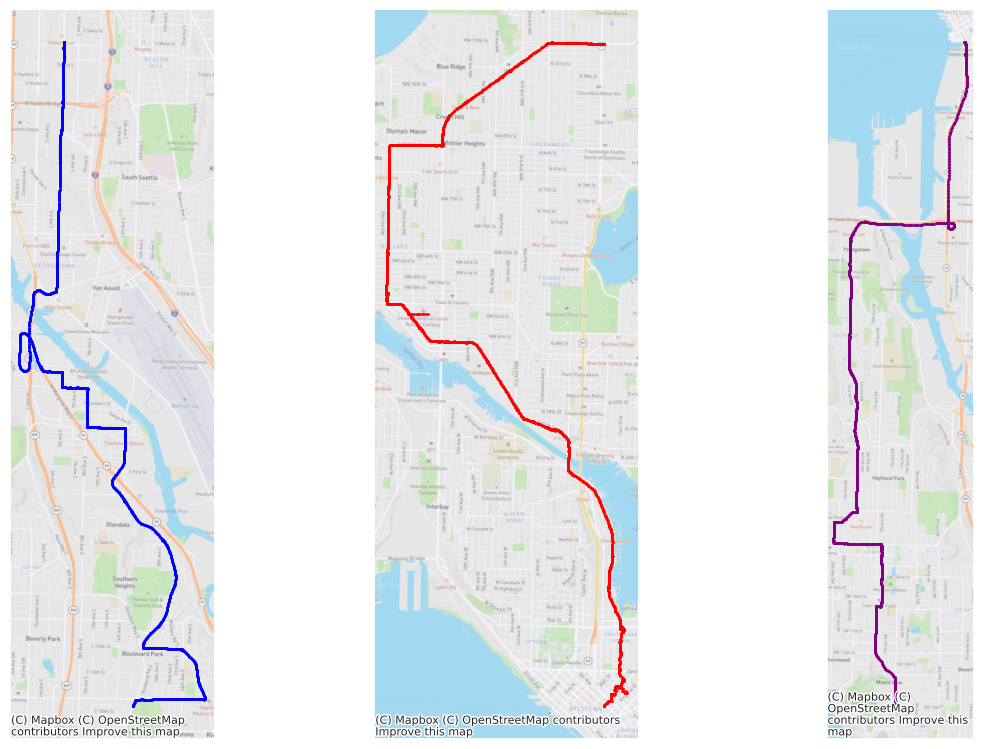

In [10]:
traj_n = 2
fig, axes = plt.subplots(1,3,figsize=(12,8))
fig.tight_layout()
axes = axes.flatten()
phone_gnss_trajectories[0].gdf.plot(ax=axes[0], color="blue", markersize=1)
phone_gnss_trajectories[1].gdf.plot(ax=axes[1], color="red", markersize=1)
phone_gnss_trajectories[2].gdf.plot(ax=axes[2], color="purple", markersize=1)
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[2].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])
cx.add_basemap(ax=axes[0], crs=phone_gnss_trajectories[0].gdf.crs.to_string(), alpha=0.6, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
cx.add_basemap(ax=axes[1], crs=phone_gnss_trajectories[1].gdf.crs.to_string(), alpha=0.6, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
cx.add_basemap(ax=axes[2], crs=phone_gnss_trajectories[2].gdf.crs.to_string(), alpha=0.6, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))

2024-04-24 11:51:38.059 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00228 exceeds tolerance of 0.001
2024-04-24 11:51:38.060 | simdrive.py:2290 | WARNING: trace miss speed 2.00775 m/s exceeds tolerance of 1.0 m/s
2024-04-24 11:51:38.327 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00272 exceeds tolerance of 0.001
2024-04-24 11:51:38.328 | simdrive.py:2290 | WARNING: trace miss speed 2.03282 m/s exceeds tolerance of 1.0 m/s
2024-04-24 11:51:38.580 | simdrive.py:459 | WARNING: large time steps affect accuracy significantly; max time step = 70.0
2024-04-24 11:51:38.584 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.06301 exceeds tolerance of 0.001
2024-04-24 11:51:38.585 | simdrive.py:2290 | WARNING: trace miss speed 2.22333 m/s exceeds tolerance of 1.0 m/s
2024-04-24 11:51:38.927 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00398 exceeds tolerance of 0.001
2024-04-24 11:51:38.929 | simdrive.py:2290 | WARNING: trace miss speed

\economies:
Avg. Phone: 1.66 kWh/mi
Avg. GNSS: 1.69 kWh/mi
Avg. Realtime: 1.63 kWh/mi



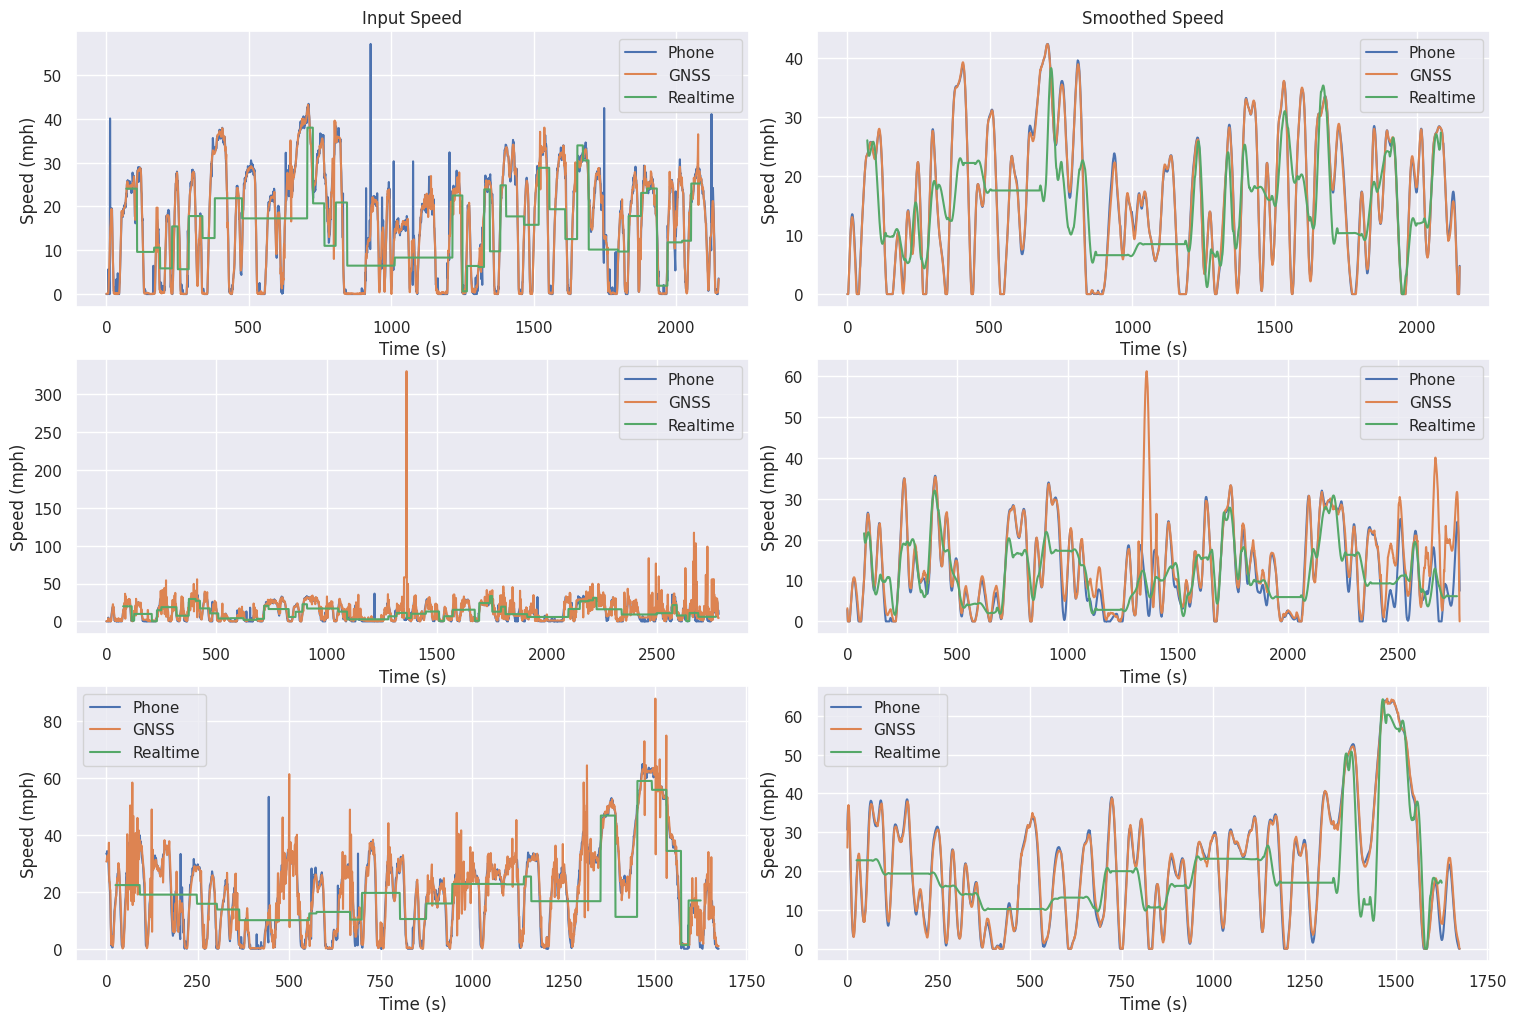

In [11]:
# Run fastsim energy analysis for each trajectory
energy_results = []
economies = []

# Phone/receiver/realtime energy consumption
for i, (traj_phone, traj_gnss, traj_realtime) in enumerate(zip(phone_trajectories, phone_gnss_trajectories, phone_realtime_trajectories)):
    # Energy analysis for phone
    cycle_phone = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_phone.gdf['calc_elev_m'], prepend=traj_phone.gdf['calc_elev_m'].iloc[0]), traj_phone.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_phone.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_phone.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_phone.gdf))
    }
    # cycle_phone = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_phone, new_dt=1))
    cycle_phone = fsim.cycle.Cycle.from_dict(cycle_phone)
    sim_drive_phone = fsim.simdrive.SimDrive(cycle_phone, veh)
    sim_drive_phone.sim_drive()
    # Energy analysis for GNSS
    cycle_gnss = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_gnss.gdf['calc_elev_m'], prepend=traj_gnss.gdf['calc_elev_m'].iloc[0]), traj_gnss.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_gnss.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_gnss.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_gnss.gdf))
    }
    cycle_gnss = fsim.cycle.Cycle.from_dict(cycle_gnss)
    sim_drive_gnss = fsim.simdrive.SimDrive(cycle_gnss, veh)
    sim_drive_gnss.sim_drive()
    # Energy analysis for realtime
    cycle_realtime = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_realtime.gdf['calc_elev_m'], prepend=traj_realtime.gdf['calc_elev_m'].iloc[0]), traj_realtime.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_realtime.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_realtime.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_realtime.gdf))
    }
    cycle_realtime = fsim.cycle.Cycle.from_dict(cycle_realtime)
    sim_drive_realtime = fsim.simdrive.SimDrive(cycle_realtime, veh)
    sim_drive_realtime.sim_drive()
    energy_results.append({"phone": (cycle_phone, sim_drive_phone), "gnss": (cycle_gnss, sim_drive_gnss), "realtime": (cycle_realtime, sim_drive_realtime)})
    economies.append((sim_drive_phone.electric_kwh_per_mi, sim_drive_gnss.electric_kwh_per_mi, sim_drive_realtime.electric_kwh_per_mi))

print(f"\economies:")
print(f"Avg. Phone: {np.mean([x[0] for x in economies]):.2f} kWh/mi")
print(f"Avg. GNSS: {np.mean([x[1] for x in economies]):.2f} kWh/mi")
print(f"Avg. Realtime: {np.mean([x[2] for x in economies]):.2f} kWh/mi\n")

fig, axes = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout()
for traj_n in range(3):
    ax = axes[traj_n,0]
    ax.set_ylabel("Speed (mph)")
    ax.set_xlabel("Time (s)")
    sns.lineplot(x=phone_trajectories[traj_n].gdf["cumul_time_s"], y=phone_trajectories[traj_n].gdf["calc_speed_m_s"]*2.2, ax=ax, label="Phone")
    sns.lineplot(x=phone_gnss_trajectories[traj_n].gdf["cumul_time_s"], y=phone_gnss_trajectories[traj_n].gdf["calc_speed_m_s"]*2.2, ax=ax, label="GNSS")
    sns.lineplot(x=phone_realtime_trajectories[traj_n].gdf["cumul_time_s"], y=phone_realtime_trajectories[traj_n].gdf["calc_speed_m_s"]*2.2, ax=ax, label="Realtime")
for traj_n in range(3):
    ax = axes[traj_n,1]
    ax.set_ylabel("Speed (mph)")
    ax.set_xlabel("Time (s)")
    sim_drive_phone, sim_drive_gnss, sim_drive_realtime = energy_results[traj_n]["phone"][1], energy_results[traj_n]["gnss"][1], energy_results[traj_n]["realtime"][1]
    sns.lineplot(x=sim_drive_phone.cyc.time_s, y=sim_drive_phone.cyc.mph, ax=ax, label="Phone")
    sns.lineplot(x=sim_drive_gnss.cyc.time_s, y=sim_drive_gnss.cyc.mph, ax=ax, label="GNSS")
    sns.lineplot(x=sim_drive_realtime.cyc.time_s, y=sim_drive_realtime.cyc.mph, ax=ax, label="Realtime")
axes[0,0].set_title("Input Speed")
axes[0,1].set_title("Smoothed Speed")
plt.show()

In [ ]:
plotting.drive_cycle_energy_plot(energy_results)

### Mean Realtime, Model Predicted Comparison

In [ ]:
# Load a static feed and break each shape into regularly spaced points
static_file = Path("..", "data", "kcm_static", "2024_03_08")
static_feed = gk.read_feed(static_file, dist_units="km")
route_shape_points = standardfeeds.segmentize_shapes(static_feed, epsg=epsg, point_sep_m=point_sep_m)
route_shape_points

In [ ]:
# Load set of realtime data to aggregate to route shapes; join it to static feed ids
realtime_files = [Path("..", "data", "kcm_realtime", "processed", "analysis", f"2024_03_1{x}.pkl") for x in np.arange(5)]
realtime_data = [pd.read_pickle(i) for i in realtime_files]
realtime_data = pd.concat(realtime_data)
realtime_data = pd.merge(realtime_data[['calc_speed_m_s', 'x', 'y', 'trip_id']], static_feed.trips[['trip_id', 'shape_id']], on='trip_id')
realtime_data = gpd.GeoDataFrame(realtime_data, geometry=gpd.points_from_xy(realtime_data.x, realtime_data.y), crs=epsg)

# Group realtime data by shape and find closest static point in that shape for each observation
route_shape_metrics = realtime_data.groupby('shape_id').apply(lambda x: gpd.sjoin_nearest(x, route_shape_points[x.name]), include_groups=False)
route_shape_metrics = route_shape_metrics.drop(columns=['shape_id']).reset_index()
route_shape_metrics = route_shape_metrics.groupby(['shape_id', 'seq_id'], as_index=False).agg({
    'calc_speed_m_s': ['mean', 'std'],
    'trip_id': 'count',
    'geometry': 'first'
})
route_shape_metrics = {
    'geometry': route_shape_metrics[('geometry', 'first')],
    'speed_mean': route_shape_metrics[('calc_speed_m_s', 'mean')],
    'speed_std': route_shape_metrics[('calc_speed_m_s', 'std')],
    'count_n': route_shape_metrics[('trip_id', 'count')],
    'shape_id': route_shape_metrics['shape_id'],
    'seq_id': route_shape_metrics['seq_id']
}
route_shape_metrics = gpd.GeoDataFrame(route_shape_metrics, crs=epsg)
route_shape_metrics.head()

In [ ]:
# Subset of shape_ids for testing
good_routes = ['20033002', '11345009', '20345010', '10027004']
bad_routes = ['10057005', '30165010', '30271024', '10102003']
plot_routes = good_routes
# plot_routes = route_shape_metrics.sample(4, random_state=2822)['shape_id'].to_numpy()
plot_df = route_shape_metrics[route_shape_metrics['shape_id'].isin(plot_routes)].copy()
plot_df_groups = {k: v for k, v in plot_df.groupby('shape_id')}

In [ ]:
# Turning regularly spaced points w/speeds into calculated distances and times
# Important to base distance on sequence id because some points do not have observations
for k,df in plot_df_groups.items():
    plot_df_groups[k]['cumul_dist_m'] = df['seq_id'] * point_sep_m
    plot_df_groups[k]['calc_dist_m'] = df['cumul_dist_m'].diff().fillna(0)
    plot_df_groups[k]['calc_time_s'] = df['calc_dist_m'] / df['speed_mean']
    plot_df_groups[k]['cumul_time_s'] = df['calc_time_s'].cumsum()
    plot_df_groups[k]['speed_std'] = df['speed_std'].bfill().ffill()

In [ ]:
# Overview of the routes
fig, axes = plt.subplots(1,len(plot_df_groups), figsize=(30,5))
fig.tight_layout()
for i, (k,df) in enumerate(plot_df_groups.items()):
    ax = axes[i]
    ax.plot(df['cumul_dist_m'], df['speed_mean'], label="Mean Speed")
    ax.fill_between(df['cumul_dist_m'], df['speed_mean'] - df['speed_std'], df['speed_mean'] + df['speed_std'], alpha=0.2, label="Speed Std")
    ax.set_xlabel("Distance [m]")
    ax.set_ylabel("Speed [m/s]")
    ax.set_title(f"Shape {k}")
    ax.legend()

In [ ]:
# Map of the routes
fig, axes = plt.subplots(1,len(plot_df_groups), figsize=(30,5))
fig.tight_layout()
for i, (k,df) in enumerate(plot_df_groups.items()):
    ax = axes[i]
    df.plot(ax=ax, column='speed_mean', cmap='plasma', legend=True)
    cx.add_basemap(ax=ax, crs=plot_df.crs.to_string(), alpha=0.6, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
    ax.set_title(f"Shape {k}")

In [ ]:
# Create trajectory for each shape
plot_trajectories = []
for shape_id, df in plot_df_groups.items():
    traj = trajectory.Trajectory(
        point_attr={
            "lon": df.to_crs(4326).geometry.x.to_numpy(),
            "lat": df.to_crs(4326).geometry.y.to_numpy(),
            "locationtime": df.cumul_time_s.to_numpy(),
            "measured_speed_m_s": df.speed_mean.to_numpy(),
            "seq_id": df.seq_id.to_numpy(),
            "count_n": df.count_n.to_numpy()
        },
        traj_attr={
            'shape_id': shape_id,
            "coord_ref_center": coord_ref_center,
            "epsg": epsg,
            "dem_file": dem_file,
            "t_min_of_day": 9*60,
            "t_day_of_week": 4,
            "start_epoch": df.cumul_time_s.iloc[0],
            "end_epoch": df.cumul_time_s.iloc[-1]
        },
        resample=False
    )
    plot_trajectories.append(traj)

In [ ]:
# Predict speeds along each trajectory
busnetwork.update_travel_times(plot_trajectories, model)

In [ ]:
energy_results = []
economies = []
mpgge = []

for i, traj in enumerate(plot_trajectories):
    # Energy analysis for aggregated
    cycle_agg = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj.gdf['calc_elev_m'], prepend=traj.gdf['calc_elev_m'].iloc[0]), traj.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj.gdf))
    }
    cycle_agg = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_agg, new_dt=1))
    sim_drive_agg = fsim.simdrive.SimDrive(cycle_agg, veh)
    sim_drive_agg.sim_drive()
    # Energy analysis for predicted
    cycle_pred = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj.gdf['calc_elev_m'], prepend=traj.gdf['calc_elev_m'].iloc[0]), traj.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj.gdf["pred_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj.gdf))
    }
    cycle_pred = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_pred, new_dt=1))
    sim_drive_pred = fsim.simdrive.SimDrive(cycle_pred, veh)
    sim_drive_pred.sim_drive()
    energy_results.append({"agg": (cycle_agg, sim_drive_agg), "pred": (cycle_pred, sim_drive_pred)})
    economies.append((sim_drive_agg.electric_kwh_per_mi, sim_drive_pred.electric_kwh_per_mi))
    mpgge.append((sim_drive_agg.mpgge, sim_drive_pred.mpgge))

print(f"economies:")
print(f"Avg. Agg: {np.mean([x[0] for x in economies]):.2f} kWh/mi")
print(f"Avg. Pred: {np.mean([x[1] for x in economies]):.2f} kWh/mi\n")
print(f"RMSE Agg/Pred: {np.sqrt(np.mean([(x-y)**2 for x,y in economies])):.2f} kWh/mi")

In [ ]:
plotting.drive_cycle_energy_plot(energy_results)

### Compare Cycle Filtering, Boosting Accuracy of Predicted GTFS-RT

In [ ]:
# Compare the smoothing / peaking of the aggregated data to the model predictions
fig, axes = plt.subplots(len(plot_trajectories), 3, figsize=(15,10))
for i in range(len(plot_trajectories)):
    # Unfiltered
    sns.lineplot(data=plot_trajectories[i].gdf, x='cumul_time_s', y='calc_speed_m_s', label='calc', ax=axes[i,0])
    sns.lineplot(data=plot_trajectories[i].gdf, x='cumul_time_s', y='pred_speed_m_s', label='pred', ax=axes[i,0])
    axes[i,0].set_title("Unfiltered")
    # Smoothed
    calc_smoothed = spatial.apply_sg_filter(plot_trajectories[i].gdf['calc_speed_m_s'].to_numpy(), window_len_factor=.1, clip_min=0, clip_max=30)
    pred_smoothed = spatial.apply_sg_filter(plot_trajectories[i].gdf['pred_speed_m_s'].to_numpy(), window_len_factor=.1, clip_min=0, clip_max=30)
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=calc_smoothed, label='calc', ax=axes[i,1])
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=pred_smoothed, label='pred', ax=axes[i,1])
    axes[i,1].set_title("SG-Smoothed")
    # Peaked then smoothed
    calc_peak_smoothed = spatial.apply_sg_filter(spatial.apply_peak_filter(plot_trajectories[i].gdf['calc_speed_m_s'].to_numpy(), scalar=5.0, clip_min=0, clip_max=30), window_len_factor=.1, clip_min=0, clip_max=30)
    pred_peak_smoothed = spatial.apply_sg_filter(spatial.apply_peak_filter(plot_trajectories[i].gdf['pred_speed_m_s'].to_numpy(), scalar=5.0, clip_min=0, clip_max=30), window_len_factor=.1, clip_min=0, clip_max=30)
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=calc_peak_smoothed, label='calc', ax=axes[i,2])
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=pred_peak_smoothed, label='pred', ax=axes[i,2])
    axes[i,2].set_title("Peaked then SG-Smoothed")
axes[0,0].legend()
axes[0,1].legend()
fig.tight_layout()